In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
import os
import random
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.datasets import load_files
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

import keras
from keras.applications import inception_v3
from keras import layers
from keras import metrics
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Flatten
from keras import optimizers
from keras import models
from keras.models import Sequential
from keras.utils import plot_model, np_utils
from keras.preprocessing import image

Using TensorFlow backend.


In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if (log.get('acc')> 0.996):
            print('reached 99,6% accuracy! stop training')
            self.model.stop_training = True

In [ ]:
callback = myCallback()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
with zipfile.ZipFile("/content/drive/My Drive/fruits.zip", 'r') as zip_ref:
    zip_ref.extractall('/content')


In [ ]:
img_size = 100
batch_size = 128
epochs = 50
channel = 3
learning_rate = 0.00001

In [ ]:
train_dir = '/content/fruits-360_dataset/fruits-360/Training'
test_dir = '/content/fruits-360_dataset/fruits-360/Test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)
print('Loading complete!')

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Loading complete!
Training set size :  60498
Testing set size :  20622


In [ ]:
no_of_classes = len(np.unique(y_train))
no_of_classes

120

In [ ]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)

In [ ]:
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(image.img_to_array(image.load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)


x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)

Training set shape :  (60498, 100, 100, 3)
Test set shape :  (20622, 100, 100, 3)
1st training image shape  (100, 100, 3)


In [ ]:
x_train = x_train/255.0
x_test = x_test/255.0

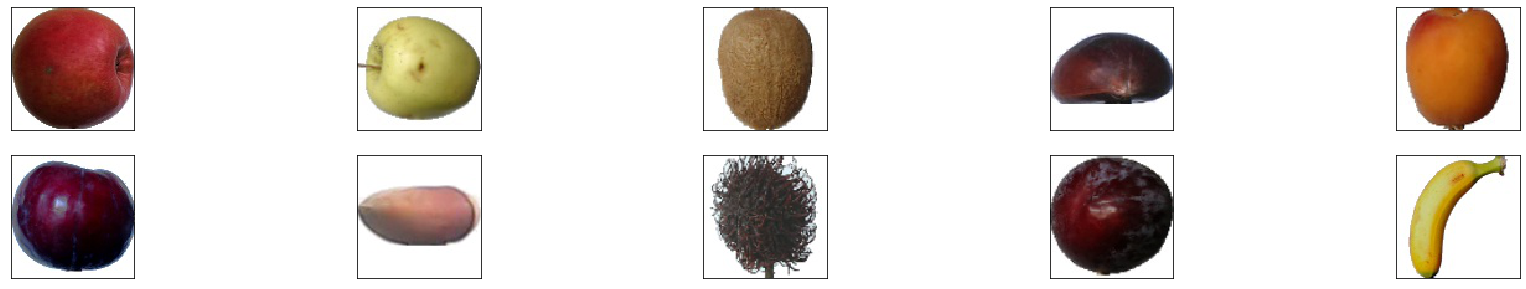

In [ ]:
fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [ ]:
base_model = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=(img_size, img_size, channel))
base_model.summary()














87916544/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 49, 49, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 49, 49, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 49, 49, 32)   0           batch_normalization_1[0][0]      
_________

In [ ]:
#for layer in base_model.layers:
    #layer.trainable = False

In [ ]:
model = models.Sequential()

model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(no_of_classes, activation='softmax'))
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_____

In [ ]:
model.compile(optimizer=optimizers.adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, callbacks=[callback], validation_split=0.2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48398 samples, validate on 12100 samples
Epoch 1/50
48398/48398 [==============================] - 94s 2ms/step - loss: 4.7792 - acc: 0.0162 - val_loss: 4.6209 - val_acc: 0.1127
Epoch 2/50
48398/48398 [==============================] - 67s 1ms/step - loss: 4.3955 - acc: 0.0791 - val_loss: 3.7872 - val_acc: 0.3326
Epoch 3/50
48398/48398 [==============================] - 67s 1ms/step - loss: 3.4728 - acc: 0.2649 - val_loss: 2.4621 - val_acc: 0.5971
Epoch 4/50
48398/48398 [==============================] - 67s 1ms/step - loss: 2.3643 - acc: 0.4979 - val_loss: 1.3491 - val_acc: 0.7949
Epoch 5/50
48398/48398 [==============================] - 67s 1ms/step - loss: 1.4121 - acc: 0.6974 - val_loss: 0.5823 - val_acc: 0.9112
Epoch 6/50
48398/48398 [==============================] - 67s 1ms/step - loss: 0.7537 - acc: 0.8401 - val_loss: 0.2161 - val_acc: 0.9724
Epoch 7/50
48398/48398 [======

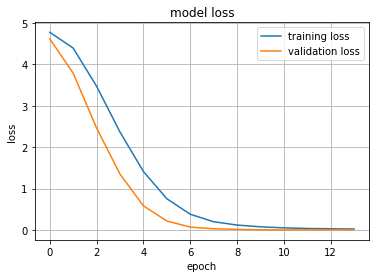

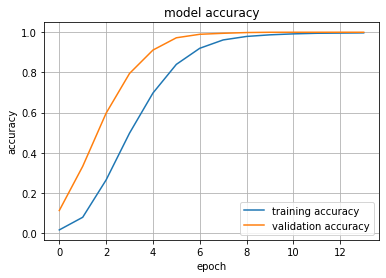

In [ ]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

20622/20622 [==============================] - 17s 809us/step
Test loss: 0.09557112429735107
Test accuracy: 0.975172146251576


In [ ]:
model.save('trained.h5')

In [ ]:
y_pred = model.predict(x_test)
y_pred_label = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true, y_pred_label)
print(report)

              precision    recall  f1-score   support

           0       0.69      1.00      0.82       164
           1       0.99      0.91      0.95       148
           2       1.00      0.99      1.00       164
           3       0.98      1.00      0.99       164
           4       0.92      0.95      0.93       161
           5       0.96      0.84      0.90       164
           6       0.91      1.00      0.95       152
           7       0.97      0.88      0.93       164
           8       0.77      0.74      0.76       164
           9       0.92      0.92      0.92       144
          10       1.00      1.00      1.00       166
          11       1.00      0.88      0.94       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       0.99      1.00      0.99       143
          15       0.99      1.00      1.00       166
          16       0.87      0.98      0.92       166
          17       0.99    